# transmon_simulator.py

In [11]:
# copy file here to modify

In [1]:
import numpy as np
from transmon_simulator import TransmonSimulator
from utility import *
from calibration import calibration_loss_1channel, calibration

# Calibration: one by one

In [7]:
MHz = 1e6
GHz = 1e9
nanosec = 1e-9

# simulator
num_transmon = 2
num_level = 3
qubit_indices,_ = qubit_subspace(num_level,num_transmon)

dt = 1.7*nanosec
anharm   = 2*np.pi * np.array([-319.7,-320.2])*MHz
drive    = 2*np.pi * np.array([30,200,30,200])*MHz
detune   = 2*np.pi * np.array([115,0])*MHz
coupling = 2*np.pi * np.array([1.87])*MHz
ctrl_noise = 0

params = {'num_transmon': num_transmon,
          'num_level': num_level,
          'dt': dt,
          'ctrl': {'anharm': anharm,
                   'drive': drive, 
                   'detune': detune,
                   'coupling': coupling,
                  },
          'ctrl_noise': ctrl_noise,
          'sim_frame_rotation': False,
         }
sim = TransmonSimulator(params)


channel_labels = ['d0','u01','d1','d10']
gate = common_gate('HH')
U_target = np.eye(num_level**num_transmon,dtype=np.complex128)
U_target[qubit_indices] = gate

initial_Z_thetas = [np.pi/2,np.pi/2]
# initial_Z_thetas = x_HI[3:]+x_IH[3:]

num_seg = 10
duration = 17 #in ns

dt = duration/num_seg*nanosec
time_step = np.linspace(0,num_seg,num_seg+1)


# drag HI
amp,sig,beta = [1,0.27,2.3] 
# amp,beta,sig = x_HI[:3]
drag_pulse_0 = DRAG(num_seg, amp, sig, beta)
# drag IH
amp,sig,beta = [1,0.2,-0.2]
# amp,beta,sig = x_IH[:3]
drag_pulse_1 = DRAG(num_seg, amp, sig, beta)


# combine
drag_total_pulse = np.zeros([len(drag_pulse_0),8])
# drag_total_pulse[:,:2] = drag_pulse_0
# drag_total_pulse[:,4:6] = drag_pulse_1
drag_total_pulse[:,:2] = Z_shift(drag_pulse_0,initial_Z_thetas[0])
drag_total_pulse[:,4:6] = Z_shift(drag_pulse_1,initial_Z_thetas[1])
total_pulse = np.vstack([drag_total_pulse])
# plot_pulse(total_pulse,channel_labels)
# sim.pulse_average_fidelity(total_pulse, U_target, qubit_indices, initial_Z_thetas)
sim.pulse_average_fidelity(total_pulse, U_target, qubit_indices)

-   Noiseless control


0.998321901668926

In [440]:
num_transmon = 2
num_level = 3
qubit_indices,_ = qubit_subspace(num_level,num_transmon)

dt = 4*nanosec
anharm   = 2*np.pi * np.array([-319.7,-320.2])*MHz
drive    = 2*np.pi * np.array([30,300,30,300])*MHz
# drive    = 2*np.pi * np.array([10,100,10,100])*MHz
detune   = 2*np.pi * np.array([115,0])*MHz
coupling = 2*np.pi * np.array([1.87])*MHz
ctrl_noise = 0

params = {'num_transmon': num_transmon,
          'num_level': num_level,
          'dt': dt,
          'ctrl': {'anharm': anharm,
                   'drive': drive, 
                   'detune': detune,
                   'coupling': coupling,
                  },
          'ctrl_noise': ctrl_noise,
          'sim_frame_rotation': False,
         }
sim = TransmonSimulator(params)

-   Noiseless control


In [441]:
num_seg = 5

# Calibrate HI with DRAG(amp, sig, beta)
U_target = np.eye(num_level**num_transmon,dtype=np.complex128)
U_target[qubit_indices] = common_gate('HI')

channel = 0
x0 = [1,0.27,2.3,np.pi/2]
bounds = [[0.7,  0, -3, -np.pi],
          [1,  0.4,  3,  np.pi]]
args = (DRAG, num_seg, channel, U_target, qubit_indices, sim)
x_HI,f_HI = calibration(x0, calibration_loss_1channel, bounds, args)

# Calibrate IH with DRAG(amp, sig, beta)
U_target = np.eye(num_level**num_transmon,dtype=np.complex128)
U_target[qubit_indices] = common_gate('IH')

channel = 2
x0 = [1,0.2,-0.2,np.pi/2]
bounds = [[0.7,  0, -3, -np.pi],
          [1,  0.4,  3,  np.pi]]
args = (DRAG, num_seg, channel, U_target, qubit_indices, sim)
x_IH,f_IH = calibration(x0, calibration_loss_1channel, bounds, args)

Optimization terminated successfully.
         Current function value: -0.999452
         Iterations: 188
         Function evaluations: 327
Optimization terminated successfully.
         Current function value: -0.999656
         Iterations: 102
         Function evaluations: 180


In [442]:
# Calibrate CNOT with GaussianSquare(gauss_ratio, amp, sig)
num_seg = 50

U_target = np.eye(num_level**num_transmon,dtype=np.complex128)
U_target[qubit_indices] = common_gate('CNOT')

channel = 1
x0 = [0.35,0.85,0.21,0]
bounds = [[0.1, 0.7,    0, -np.pi],
          [ 0.5,   1,  0.4,  np.pi]]
args = (GaussianSquare, num_seg, channel, U_target, qubit_indices, sim)
x_CNOT,f_CNOT = calibration(x0, calibration_loss_1channel, bounds, args)

Optimization terminated successfully.
         Current function value: -0.991630
         Iterations: 99
         Function evaluations: 188


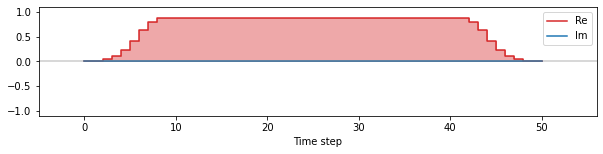

In [12]:
plot_pulse(GaussianSquare(num_seg,*x_CNOT[:-1]),[''])

## Calibrated HI

In [242]:
channel_labels = ['d0','u01','d1','d10']
U_target = np.eye(num_level**num_transmon,dtype=np.complex128)
U_target[qubit_indices] = common_gate('HI')

# drag HI
# amp,sig,beta = [1,0.27,2.3] 
num_seg = 5
amp,sig,beta = x_HI[:-1]
drag_pulse_0 = Z_shift(DRAG(num_seg, amp, sig, beta),x_HI[-1])


# combine
drag_total_pulse = np.zeros([len(drag_pulse_0),8])
drag_total_pulse[:,:2] = drag_pulse_0
total_pulse = np.vstack([drag_total_pulse])
# plot_pulse(total_pulse,channel_labels)
avg_fids, next_thetas,U = sim.pulse_average_fidelities(total_pulse, U_target, qubit_indices)
print(next_thetas)
avg_fids[-1]

[-1.0441708626591784, -0.0005088641732668018]


0.9994522913617153

In [237]:
vZ = Zgate_on_all(next_thetas,num_level=3)
print(sim.pulse_average_fidelity(total_pulse, vZ.conj().T@U_target, qubit_indices,[],False))

M,_ = projected_overlap(vZ@U@vZ@U,np.eye(9),qubit_indices)
average_over_pure_states(M)

0.9994522913617153


0.9993665287243829

In [182]:
num_seg = 5
amp,sig,beta = x_HI[:-1]
drag_pulse_0 = Z_shift(DRAG(num_seg, amp, sig, beta),x_HI[-1]+next_thetas[0])

rag_total_pulse = np.zeros([len(drag_pulse_0),8])
drag_total_pulse[:,:2] = drag_pulse_0
total_pulse = np.vstack([drag_total_pulse])
# plot_pulse(total_pulse,channel_labels)
avg_fids, _,UvZ = sim.pulse_average_fidelities(total_pulse, U_target, qubit_indices)

In [158]:
M,theta = projected_overlap(vZ@U,U_target,qubit_indices,False)
average_over_pure_states(M)

0.9994522913617153

In [163]:
M.round(2)

array([[[ 1.  +0.02j,  0.01+0.j  ,  0.  -0.j  ,  0.01-0.j  ],
        [-0.01-0.j  ,  1.  +0.02j,  0.02+0.01j,  0.  +0.j  ],
        [-0.  -0.j  , -0.02+0.01j,  1.  +0.02j, -0.01+0.j  ],
        [-0.01-0.j  , -0.  +0.j  ,  0.01+0.j  ,  1.  +0.02j]]])

In [166]:
U2 = ((vZ@U)[qubit_indices]@(vZ@U)[qubit_indices])

In [169]:
(U2/U2[0,0]).round(1)

array([[ 1.+0.j,  0.+0.j,  0.-0.j,  0.+0.j],
       [-0.+0.j,  1.+0.j, -0.+0.j,  0.+0.j],
       [ 0.-0.j,  0.+0.j,  1.+0.j, -0.-0.j],
       [-0.+0.j,  0.+0.j,  0.-0.j,  1.-0.j]])

In [147]:
U_target[qubit_indices]@U_target[qubit_indices]

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

[-2.080776769499921, -0.001537788660231478]
0.9990185379637483 -2.921681167838508


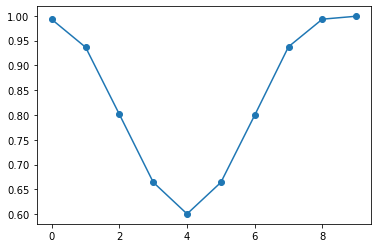

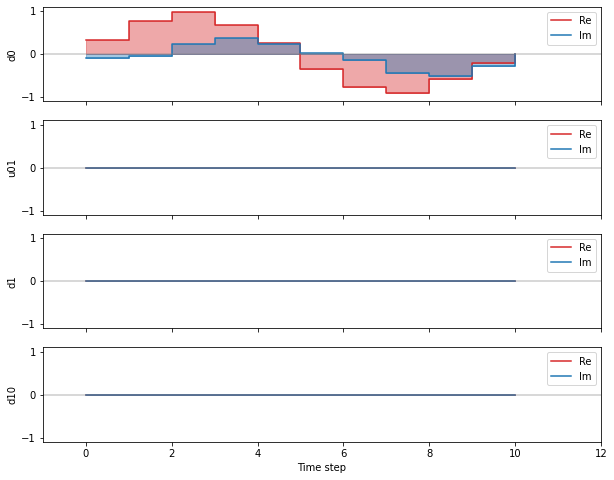

In [264]:
channel_labels = ['d0','u01','d1','d10']
U_target = np.eye(num_level**num_transmon,dtype=np.complex128)
U_target[qubit_indices] = common_gate('II')

num_seg = 5

############ first HI ############
amp,sig,beta = x_HI[:-1]
drag_pulse_0 = Z_shift(DRAG(num_seg, amp, sig, beta),x_HI[-1])

H_pulse_1 = np.zeros([len(drag_pulse_0),8])
H_pulse_1[:,:2] = drag_pulse_0

theta = -np.pi*0.93
############ second HI ############
amp,sig,beta = x_HI[:-1]
drag_pulse_0 = Z_shift(DRAG(num_seg, amp, sig, beta),x_HI[-1]+theta)

H_pulse_2 = np.zeros([len(drag_pulse_0),8])
H_pulse_2[:,:2] = drag_pulse_0

total_pulse = np.vstack([H_pulse_1,H_pulse_2])
avg_fids, thetas,U2 = sim.pulse_average_fidelities(total_pulse, U_target, qubit_indices)
print(thetas)
print(avg_fids[-1],theta)
plt.plot(avg_fids,'o-')
plt.show()
plot_pulse(total_pulse,channel_labels)

In [ ]:
vZ = Zgate_on_all(next_thetas,num_level=3)
sim.pulse_average_fidelity(total_pulse, vZ.conj().T@U_target, qubit_indices,[],False)

0.9994636904473959

## Calibrate NOTC

In [311]:
channel_labels = ['d0','u01','d1','d10']
U_target = np.eye(num_level**num_transmon,dtype=np.complex128)

U_target[qubit_indices] = common_gate('NOTC')

# drag HI
num_seg = 5
amp,sig,beta = x_HI[:-1]
drag_pulse_0 = Z_shift(DRAG(num_seg, amp, sig, beta),x_HI[-1])

# drag IH
num_seg = 5
amp,sig,beta = x_IH[:-1]
drag_pulse_1 = Z_shift(DRAG(num_seg, amp, sig, beta),x_IH[-1])

# GS CNOT
num_seg = 50
gauss_ratio, amp, sig = x_CNOT[:-1]
GS_pulse = GaussianSquare(num_seg, gauss_ratio, amp, sig)

# combine
HH_pulse_1 = np.zeros([len(drag_pulse_0),8])
HH_pulse_1[:,:2] = drag_pulse_0
HH_pulse_1[:,4:6] = drag_pulse_1

In [ ]:
def NOTC_loss(x):
    cnot_pulse = np.zeros([len(GS_pulse),8])
    cnot_pulse[:,2:4] = Z_shift(GS_pulse,x[0])

    HH_pulse_2 = np.zeros([len(drag_pulse_0),8])
    HH_pulse_2[:,:2] = Z_shift(drag_pulse_0,x[1]) 
    HH_pulse_2[:,4:6] = Z_shift(drag_pulse_1,x[2])
    total_pulse = np.vstack([HH_pulse_1,cnot_pulse,HH_pulse_2])
    return -sim.pulse_average_fidelity(total_pulse, U_target, qubit_indices)

x0 = np.array([-0.105,0.989,0.944])*np.pi
# x0 = np.zeros(3)
bounds = [[-np.pi,-np.pi,-np.pi],
          [np.pi,np.pi,np.pi]]
args = ()
x_NOTC,f_NOTC = calibration(x0, NOTC_loss, bounds, args)
x_NOTC

Optimization terminated successfully.
         Current function value: -0.992710
         Iterations: 54
         Function evaluations: 101


array([-0.46248818,  3.07479481,  2.73190108])

In [319]:
# def NOTC_loss(x):
#     HH_pulse_1 = np.zeros([len(drag_pulse_0),8])
#     HH_pulse_1[:,:2] = Z_shift(drag_pulse_0,x[0]) 
#     HH_pulse_1[:,4:6] = Z_shift(drag_pulse_1,x[1])

#     cnot_pulse = np.zeros([len(GS_pulse),8])
#     cnot_pulse[:,2:4] = Z_shift(GS_pulse,x[2])

#     HH_pulse_2 = np.zeros([len(drag_pulse_0),8])
#     HH_pulse_2[:,:2] = Z_shift(drag_pulse_0,x[3]) 
#     HH_pulse_2[:,4:6] = Z_shift(drag_pulse_1,x[4])
#     total_pulse = np.vstack([HH_pulse_1,cnot_pulse,HH_pulse_2])
#     return -sim.pulse_average_fidelity(total_pulse, U_target, qubit_indices)

# x0 = np.array([0.074,0.414,-0.105,0.989,0.944])*np.pi
# bounds = [[-np.pi,-np.pi,-np.pi,-np.pi,-np.pi],
#           [np.pi,np.pi,np.pi,np.pi,np.pi]]
# args = ()
# x_NOTC,f_NOTC = calibration(x0, NOTC_loss, bounds, args)
# x_NOTC

Optimization terminated successfully.
         Current function value: -0.993083
         Iterations: 461
         Function evaluations: 737


array([ 0.02149879,  0.41830565, -0.04503169,  3.09840423,  3.14153095])

[-2.3685917108666095, -1.0228706447569793]
0.9927099996332153


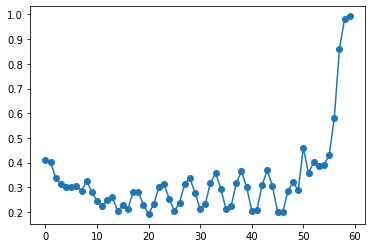

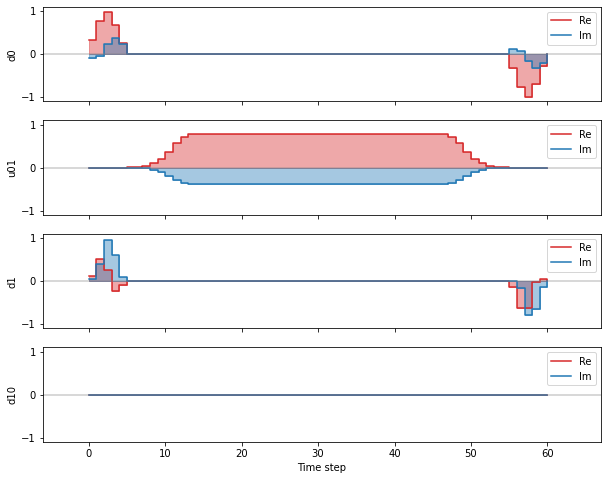

In [337]:
channel_labels = ['d0','u01','d1','d10']
U_target = np.eye(num_level**num_transmon,dtype=np.complex128)
U_target[qubit_indices] = common_gate('NOTC')

# drag HI
num_seg = 5
amp,sig,beta = x_HI[:-1]
drag_pulse_0 = Z_shift(DRAG(num_seg, amp, sig, beta),x_HI[-1])

# drag IH
num_seg = 5
amp,sig,beta = x_IH[:-1]
drag_pulse_1 = Z_shift(DRAG(num_seg, amp, sig, beta),x_IH[-1])

# GS CNOT
num_seg = 50
gauss_ratio, amp, sig = x_CNOT[:-1]
GS_pulse = GaussianSquare(num_seg, gauss_ratio, amp, sig)

# combine
HH_pulse_1 = np.zeros([len(drag_pulse_0),8])
HH_pulse_1[:,:2] = drag_pulse_0
HH_pulse_1[:,4:6] = drag_pulse_1

cnot_pulse = np.zeros([len(GS_pulse),8])
cnot_pulse[:,2:4] = Z_shift(GS_pulse,x_NOTC[0])

HH_pulse_2 = np.zeros([len(drag_pulse_0),8])
HH_pulse_2[:,:2] = Z_shift(drag_pulse_0,x_NOTC[1]) 
HH_pulse_2[:,4:6] = Z_shift(drag_pulse_1,x_NOTC[2])
total_pulse = np.vstack([HH_pulse_1,cnot_pulse,HH_pulse_2])
NOTC_pulse = total_pulse.copy()

avg_fids, next_thetas,U = sim.pulse_average_fidelities(total_pulse, U_target, qubit_indices)
print(next_thetas)
print(avg_fids.max())
plt.plot(avg_fids,'o-')
plt.show()
plot_pulse(total_pulse,channel_labels)

## Calibrate SWAP

In [360]:
channel_labels = ['d0','u01','d1','d10']
U_target = np.eye(num_level**num_transmon,dtype=np.complex128)
U_target[qubit_indices] = common_gate('SWAP')

# GS CNOT
GS_pulse = GaussianSquare(50, *x_CNOT[:-1])
cnot_pulse_1 = np.zeros([len(GS_pulse),8])
cnot_pulse_1[:,2:4] = GS_pulse
notc_pulse = np.zeros_like(NOTC_pulse)

def SWAP_loss(x):
    notc_pulse[:,:2] = Z_shift(NOTC_pulse[:,:2],x[0])
    notc_pulse[:,2:4] = Z_shift(NOTC_pulse[:,2:4],x[0])
    notc_pulse[:,4:6] = Z_shift(NOTC_pulse[:,4:6],x[1])
    
    cnot_pulse_2 = np.zeros([len(GS_pulse),8])
    cnot_pulse_2[:,2:4] = Z_shift(GS_pulse,x[2])
    
    total_pulse = np.vstack([cnot_pulse_1,notc_pulse,cnot_pulse_2])
    return -sim.pulse_average_fidelity(total_pulse, U_target, qubit_indices)

x0 = (2*np.random.random(3)-1)*np.pi
# x0 = np.zeros(3)
bounds = [[-np.pi,-np.pi,-np.pi],
          [np.pi,np.pi,np.pi]]
args = ()
x_SWAP,f_SWAP = calibration(x0, SWAP_loss, bounds, args)

Optimization terminated successfully.
         Current function value: -0.979545
         Iterations: 136
         Function evaluations: 250


In [361]:
print(-f_SWAP)
print(x_SWAP)
print(x_SWAP/np.pi)

0.9795454823256957
[-0.53044987 -0.58845335  2.24255383]
[-0.16884744 -0.18731052  0.71382705]


[-3.1151586634995136, 2.5800698857335185]
0.9799830275255031


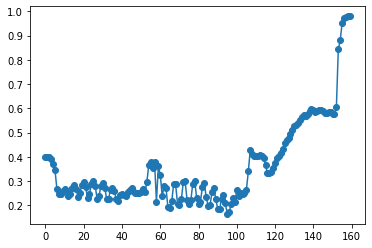

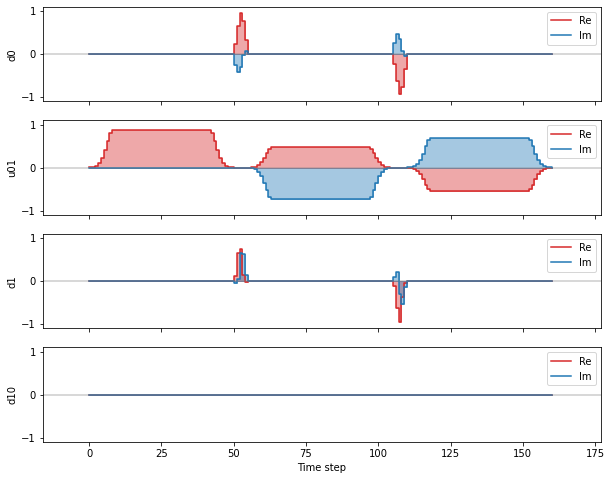

In [363]:
channel_labels = ['d0','u01','d1','d10']
U_target = np.eye(num_level**num_transmon,dtype=np.complex128)
U_target[qubit_indices] = common_gate('SWAP')

# GS CNOT
GS_pulse = GaussianSquare(50, *x_CNOT[:-1])
cnot_pulse_1 = np.zeros([len(GS_pulse),8])
cnot_pulse_1[:,2:4] = GS_pulse
notc_pulse = np.zeros_like(NOTC_pulse)

notc_pulse[:,:2] = Z_shift(NOTC_pulse[:,:2],x_SWAP[0])
notc_pulse[:,2:4] = Z_shift(NOTC_pulse[:,2:4],x_SWAP[0])
notc_pulse[:,4:6] = Z_shift(NOTC_pulse[:,4:6],x_SWAP[1])

cnot_pulse_2 = np.zeros([len(GS_pulse),8])
cnot_pulse_2[:,2:4] = Z_shift(GS_pulse,x_SWAP[2])

total_pulse = np.vstack([cnot_pulse_1,notc_pulse,cnot_pulse_2])

avg_fids, next_thetas,U = sim.pulse_average_fidelities(total_pulse, U_target, qubit_indices)
print(next_thetas)
print(avg_fids.max())
plt.plot(avg_fids,'o-')
plt.show()
plot_pulse(total_pulse,channel_labels)

# Calibration with IX90, X90I, CNOT

In [581]:
MHz = 1e6
GHz = 1e9
nanosec = 1e-9

# simulator
num_transmon = 2
num_level = 3
qubit_indices,_ = qubit_subspace(num_level,num_transmon)

dt = 4*nanosec
anharm   = 2*np.pi * np.array([-319.7,-320.2])*MHz
drive    = 2*np.pi * np.array([30,300,30,300])*MHz
detune   = 2*np.pi * np.array([115,0])*MHz
coupling = 2*np.pi * np.array([1.87])*MHz
ctrl_noise = 0

params = {'num_transmon': num_transmon,
          'num_level': num_level,
          'dt': dt,
          'ctrl': {'anharm': anharm,
                   'drive': drive, 
                   'detune': detune,
                   'coupling': coupling,
                  },
          'ctrl_noise': ctrl_noise,
          'sim_frame_rotation': False,
         }
sim = TransmonSimulator(params)

-   Noiseless control


## DRAG & GaussianSquare

In [553]:
# Calibrate DRAG(amp, sig, beta)
U_target = np.eye(num_level**num_transmon,dtype=np.complex128)
U_target[qubit_indices] = common_gate('X90I')

num_seg = 5
channel = 0
bounds = np.array([[0.7,  0, -3, -np.pi],
                   [1,  0.4,  3,  np.pi]])
x0 = [np.random.uniform(*bounds[:,i]) for i in range(bounds.shape[1])]
args = (DRAG, num_seg, channel, U_target, qubit_indices, sim)
x_X90I,f_X90I = calibration(x0, calibration_loss_1channel, bounds, args)
x_X90I

Optimization terminated successfully.
         Current function value: -0.999452
         Iterations: 395
         Function evaluations: 645


array([ 1.        ,  0.25705079, -0.46631134, -1.33888415])

In [555]:
# Calibrate DRAG(amp, sig, beta)
U_target = np.eye(num_level**num_transmon,dtype=np.complex128)
U_target[qubit_indices] = common_gate('IX90')

num_seg = 5
channel = 2
bounds = np.array([[0.7,  0, -3, -np.pi],
                   [1,  0.4,  3,  np.pi]])
x0 = [np.random.uniform(*bounds[:,i]) for i in range(bounds.shape[1])]
args = (DRAG, num_seg, channel, U_target, qubit_indices, sim)
x_IX90,f_IX90 = calibration(x0, calibration_loss_1channel, bounds, args)
x_IX90

Optimization terminated successfully.
         Current function value: -0.999674
         Iterations: 307
         Function evaluations: 514


array([ 0.71479103,  0.24319973, -0.41055427, -0.11303429])

In [657]:
# Calibrate CNOT with GaussianSquare(gauss_ratio, amp, sig)
U_target = np.eye(num_level**num_transmon,dtype=np.complex128)
U_target[qubit_indices] = common_gate('CNOT')

num_seg = 50
channel = 1
bounds = np.array([[0.1, 0.7,    0, -np.pi],
                   [0.5,    1,  0.4,  np.pi]])
# x0 = [np.random.uniform(*bounds[:,i]) for i in range(bounds.shape[1])]
x0 = [0.445,1,0.151,-0.158]*(1 + 0.1*(np.random.random(4)-0.5))
args = (GaussianSquare, num_seg, channel, U_target, qubit_indices, sim)
x_CNOT,f_CNOT = calibration(x0, calibration_loss_1channel, bounds, args)
print(x_CNOT,f_CNOT)

Optimization terminated successfully.
         Current function value: -0.992654
         Iterations: 89
         Function evaluations: 159
[ 0.45272866  1.          0.15123441 -0.15832501] -0.9926538259422513


In [ ]:
[0.44542538 1.         0.15123449 -0.1583192] -0.9926538261968731
[0.43478749 0.93341832 0.15184604 0.15240044] -0.9925931065157855
[0.41973656 0.88721655 0.15261192 0.04758285] -0.9921644038550085
[0.43999404 0.90112382 0.15718714 0.04621372] -0.9919013133397888

## SWAP
- Better optimized altogether

In [669]:
channel_labels = ['d0','u01','d1','d10']
U_target = np.eye(num_level**num_transmon,dtype=np.complex128)
U_target[qubit_indices] = common_gate('SWAP')

drag_pulse_0 = DRAG(5, *x_X90I[:-1])
drag_pulse_1 = DRAG(5, *x_IX90[:-1])
GS_pulse = GaussianSquare(50, *x_CNOT[:-1])

def SWAP_loss(x):
    cnot_pulse_1 = np.zeros([len(GS_pulse),8])
    cnot_pulse_1[:,2:4] = Z_shift(GS_pulse,x[0])
    
    hh_pulse_1 = np.zeros([len(drag_pulse_0),8])
    hh_pulse_1[:, :2] = Z_shift(drag_pulse_0,x[1])
    hh_pulse_1[:,4:6] = Z_shift(drag_pulse_1,x[2])
    
    cnot_pulse_2 = np.zeros([len(GS_pulse),8])
    cnot_pulse_2[:,2:4] = Z_shift(GS_pulse,x[3])
    
    hh_pulse_2 = np.zeros([len(drag_pulse_0),8])
    hh_pulse_2[:, :2] = Z_shift(drag_pulse_0,x[4])
    hh_pulse_2[:,4:6] = Z_shift(drag_pulse_1,x[5])
    
    cnot_pulse_3 = np.zeros([len(GS_pulse),8])
    cnot_pulse_3[:,2:4] = Z_shift(GS_pulse,x[6])
    
    total_pulse = np.vstack([cnot_pulse_1,
                             hh_pulse_1,
                             cnot_pulse_2,
                             hh_pulse_2,
                             cnot_pulse_3])
    return -sim.pulse_average_fidelity(total_pulse, U_target, qubit_indices)

bounds = np.pi*np.array([[-1,-1,-1,-1,-1,-1,-1],
                         [ 1, 1, 1, 1, 1, 1, 1]])
# x0 = [np.random.uniform(*bounds[:,i]) for i in range(bounds.shape[1])]
x0 = [0.22,1.27,0.49,-1.32,-3.,-3.,-0.92]*(1 + 0.1*(np.random.random(7)-0.5))
x_SWAP,f_SWAP = calibration(x0, SWAP_loss, bounds)
print(x_SWAP,f_SWAP)

Optimization terminated successfully.
         Current function value: -0.988471
         Iterations: 507
         Function evaluations: 762
[ 0.40192683  1.60814476  0.50891225 -1.31562956 -2.81163055 -3.13722026
 -0.74656652] -0.9884709299878089


In [ ]:
[ 0.40192683  1.60814476  0.50891225 -1.31562956 -2.81163055 -3.13722026
 -0.74656652] -0.9884709299878089
[ 0.2197839   1.27311397  0.49450416 -1.3158347  -3.14159265 -3.13039812
 -0.9154409 ] -0.988267124218523
[-0.19640728 -1.1962081   0.5956719  -1.14566282  0.84769395 -2.87404917
 -1.17117661] -0.9854079237366047
[-2.77979677  1.2173477   1.88210842  3.13918683  0.12581288 -1.80122202
 -0.6546127 ] -0.9851847203781038

In [662]:
# 6 variables, using CNOT first angle
channel_labels = ['d0','u01','d1','d10']
U_target = np.eye(num_level**num_transmon,dtype=np.complex128)
U_target[qubit_indices] = common_gate('SWAP')

drag_pulse_0 = DRAG(5, *x_X90I[:-1])
drag_pulse_1 = DRAG(5, *x_IX90[:-1])
GS_pulse = GaussianSquare(50, *x_CNOT[:-1])

def SWAP_loss(x):
    cnot_pulse_1 = np.zeros([len(GS_pulse),8])
    cnot_pulse_1[:,2:4] = Z_shift(GS_pulse,x_CNOT[-1])
    
    hh_pulse_1 = np.zeros([len(drag_pulse_0),8])
    hh_pulse_1[:, :2] = Z_shift(drag_pulse_0,x[0])
    hh_pulse_1[:,4:6] = Z_shift(drag_pulse_1,x[1])
    
    cnot_pulse_2 = np.zeros([len(GS_pulse),8])
    cnot_pulse_2[:,2:4] = Z_shift(GS_pulse,x[2])
    
    hh_pulse_2 = np.zeros([len(drag_pulse_0),8])
    hh_pulse_2[:, :2] = Z_shift(drag_pulse_0,x[3])
    hh_pulse_2[:,4:6] = Z_shift(drag_pulse_1,x[4])
    
    cnot_pulse_3 = np.zeros([len(GS_pulse),8])
    cnot_pulse_3[:,2:4] = Z_shift(GS_pulse,x[5])
    
    total_pulse = np.vstack([cnot_pulse_1,
                             hh_pulse_1,
                             cnot_pulse_2,
                             hh_pulse_2,
                             cnot_pulse_3])
    return -sim.pulse_average_fidelity(total_pulse, U_target, qubit_indices)

bounds = np.pi*np.array([[-1,-1,-1,-1,-1,-1],
                         [ 1, 1, 1, 1, 1, 1]])
x0 = [np.random.uniform(*bounds[:,i]) for i in range(bounds.shape[1])]
x_SWAP,f_SWAP = calibration(x0, SWAP_loss, bounds)
print(x_SWAP,f_SWAP)

Optimization terminated successfully.
         Current function value: -0.985923
         Iterations: 614
         Function evaluations: 985
[-2.5131807  -1.15245246  0.13612797  2.62610008  1.35904574 -1.24281278] -0.9859227400514164


In [665]:
# 6 variables, no first angle
channel_labels = ['d0','u01','d1','d10']
U_target = np.eye(num_level**num_transmon,dtype=np.complex128)
U_target[qubit_indices] = common_gate('SWAP')

drag_pulse_0 = DRAG(5, *x_X90I[:-1])
drag_pulse_1 = DRAG(5, *x_IX90[:-1])
GS_pulse = GaussianSquare(50, *x_CNOT[:-1])

def SWAP_loss(x):
    cnot_pulse_1 = np.zeros([len(GS_pulse),8])
    cnot_pulse_1[:,2:4] = Z_shift(GS_pulse,x_CNOT[-1])
    
    hh_pulse_1 = np.zeros([len(drag_pulse_0),8])
    hh_pulse_1[:, :2] = Z_shift(drag_pulse_0,x[0])
    hh_pulse_1[:,4:6] = Z_shift(drag_pulse_1,x[1])
    
    cnot_pulse_2 = np.zeros([len(GS_pulse),8])
    cnot_pulse_2[:,2:4] = Z_shift(GS_pulse,x[2])
    
    hh_pulse_2 = np.zeros([len(drag_pulse_0),8])
    hh_pulse_2[:, :2] = Z_shift(drag_pulse_0,x[3])
    hh_pulse_2[:,4:6] = Z_shift(drag_pulse_1,x[4])
    
    cnot_pulse_3 = np.zeros([len(GS_pulse),8])
    cnot_pulse_3[:,2:4] = Z_shift(GS_pulse,x[5])
    
    total_pulse = np.vstack([cnot_pulse_1,
                             hh_pulse_1,
                             cnot_pulse_2,
                             hh_pulse_2,
                             cnot_pulse_3])
    return -sim.pulse_average_fidelity(total_pulse, U_target, qubit_indices)

bounds = np.pi*np.array([[-1,-1,-1,-1,-1,-1],
                         [ 1, 1, 1, 1, 1, 1]])
x0 = [np.random.uniform(*bounds[:,i]) for i in range(bounds.shape[1])]
x_SWAP,f_SWAP = calibration(x0, SWAP_loss, bounds)
print(x_SWAP,f_SWAP)

Optimization terminated successfully.
         Current function value: -0.911508
         Iterations: 572
         Function evaluations: 897
[ 0.50250797 -1.912882   -0.31902529 -0.69955808  1.4730713  -3.14159265] -0.9115084998684597


In [670]:
U_targets = {}

U_target = np.eye(num_level**num_transmon,dtype=np.complex128)
U_target[qubit_indices] = common_gate('CNOT')
U_targets['CNOT'] = U_target

U_target = np.eye(num_level**num_transmon,dtype=np.complex128)
U_target[qubit_indices] = common_gate('NOTC')@common_gate('CNOT')
U_targets['NOTC-CNOT'] = U_target

U_target = np.eye(num_level**num_transmon,dtype=np.complex128)
U_target[qubit_indices] = common_gate('SWAP')
U_targets['SWAP'] = U_target

Max fidelity
  CNOT     : 0.9327
  NOTC-CNOT: 0.9579
  SWAP     : 0.9885


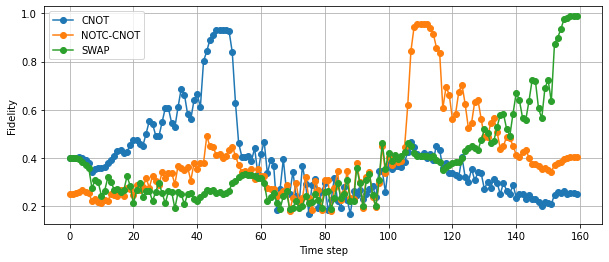


Max amp difference: 0.44


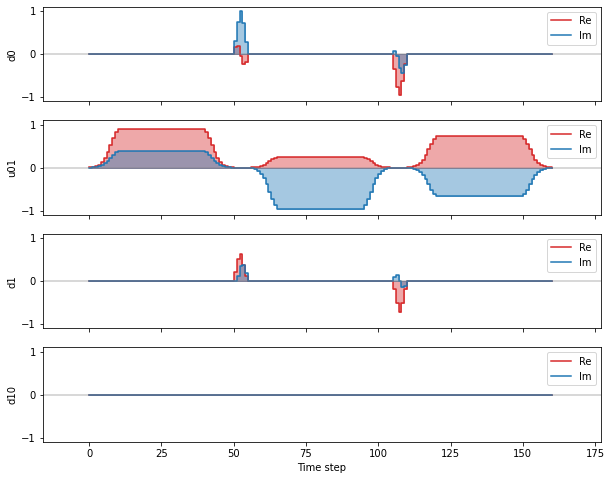

In [719]:
channel_labels = ['d0','u01','d1','d10']

drag_pulse_0 = DRAG(5, *x_X90I[:-1])
drag_pulse_1 = DRAG(5, *x_IX90[:-1])
GS_pulse = GaussianSquare(50, *x_CNOT[:-1])

cnot_pulse_1 = np.zeros([len(GS_pulse),8])
cnot_pulse_1[:,2:4] = Z_shift(GS_pulse,x_SWAP[0])

hh_pulse_1 = np.zeros([len(drag_pulse_0),8])
hh_pulse_1[:, :2] = Z_shift(drag_pulse_0,x_SWAP[1])
hh_pulse_1[:,4:6] = Z_shift(drag_pulse_1,x_SWAP[2])

cnot_pulse_2 = np.zeros([len(GS_pulse),8])
cnot_pulse_2[:,2:4] = Z_shift(GS_pulse,x_SWAP[3])

hh_pulse_2 = np.zeros([len(drag_pulse_0),8])
hh_pulse_2[:, :2] = Z_shift(drag_pulse_0,x_SWAP[4])
hh_pulse_2[:,4:6] = Z_shift(drag_pulse_1,x_SWAP[5])

cnot_pulse_3 = np.zeros([len(GS_pulse),8])
cnot_pulse_3[:,2:4] = Z_shift(GS_pulse,x_SWAP[6])

total_pulse = np.vstack([cnot_pulse_1,hh_pulse_1,
                         cnot_pulse_2,hh_pulse_2,cnot_pulse_3])
max_diff = abs(total_pulse[1:,:]-total_pulse[:-1,:]).max()
print('Max fidelity')
plt.figure(figsize=(10,4))
for gate in U_targets:
    avg_fids,_,_ = sim.pulse_average_fidelities(total_pulse, U_targets[gate], qubit_indices)
    plt.plot(avg_fids,'o-',label=gate)
    # plt.plot(NLI(avg_fids),'o-',label=gate)
    print(f'  {gate.ljust(9)}: {avg_fids.max():.4f}')
plt.xlabel('Time step')
plt.ylabel('Fidelity')
plt.legend()
plt.grid()
plt.show()

print(f'\nMax amp difference: {max_diff:.2f}')
plot_pulse(total_pulse,channel_labels)

In [690]:
print(x_X90I)
print(x_IX90)
print(x_CNOT)
print(x_SWAP)

[ 1.          0.25705079 -0.46631134 -1.33888415]
[ 0.71479103  0.24319973 -0.41055427 -0.11303429]
[ 0.45272866  1.          0.15123441 -0.15832501]
[ 0.40192683  1.60814476  0.50891225 -1.31562956 -2.81163055 -3.13722026
 -0.74656652]


# SWAP gate example

In [3]:
MHz = 1e6
GHz = 1e9
nanosec = 1e-9

# simulator
num_transmon = 2
num_level = 3
qubit_indices,_ = qubit_subspace(num_level,num_transmon)

dt = 4*nanosec
anharm   = 2*np.pi * np.array([-319.7,-320.2])*MHz
drive    = 2*np.pi * np.array([30,300,30,300])*MHz
detune   = 2*np.pi * np.array([115,0])*MHz
coupling = 2*np.pi * np.array([1.87])*MHz
ctrl_noise = 0

params = {'num_transmon': num_transmon,
          'num_level': num_level,
          'dt': dt,
          'ctrl': {'anharm': anharm,
                   'drive': drive, 
                   'detune': detune,
                   'coupling': coupling,
                  },
          'ctrl_noise': ctrl_noise,
          'sim_frame_rotation': False,
         }
sim = TransmonSimulator(params)

U_target = np.eye(num_level**num_transmon,dtype=np.complex128)
U_target[qubit_indices] = common_gate('SWAP')

# Saved optimized angles
x_X90I = np.array([ 1.        ,  0.25705079, -0.46631134, -1.33888415])
x_IX90 = np.array([ 0.71479103,  0.24319973, -0.41055427, -0.11303429])
x_CNOT = np.array([ 0.45272866,  1.        ,  0.15123441, -0.15832501])
x_SWAP = np.array([ 0.40192683, 1.60814476 ,  0.50891225, -1.31562956, 
                   -2.81163055, -3.13722026, -0.74656652])

-   Noiseless control


Max fidelity
  Average: 0.9885


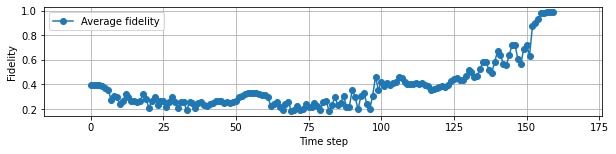

Max amp difference: 0.44


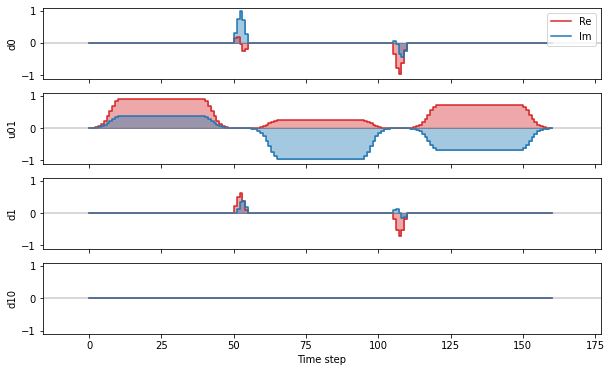

In [15]:
channel_labels = ['d0','u01','d1','d10']

drag_pulse_0 = DRAG(5, *x_X90I[:-1])
drag_pulse_1 = DRAG(5, *x_IX90[:-1])
GS_pulse = GaussianSquare(50, *x_CNOT[:-1])

cnot_pulse_1 = np.zeros([len(GS_pulse),8])
cnot_pulse_1[:,2:4] = Z_shift(GS_pulse,x_SWAP[0])

hh_pulse_1 = np.zeros([len(drag_pulse_0),8])
hh_pulse_1[:, :2] = Z_shift(drag_pulse_0,x_SWAP[1])
hh_pulse_1[:,4:6] = Z_shift(drag_pulse_1,x_SWAP[2])

cnot_pulse_2 = np.zeros([len(GS_pulse),8])
cnot_pulse_2[:,2:4] = Z_shift(GS_pulse,x_SWAP[3])

hh_pulse_2 = np.zeros([len(drag_pulse_0),8])
hh_pulse_2[:, :2] = Z_shift(drag_pulse_0,x_SWAP[4])
hh_pulse_2[:,4:6] = Z_shift(drag_pulse_1,x_SWAP[5])

cnot_pulse_3 = np.zeros([len(GS_pulse),8])
cnot_pulse_3[:,2:4] = Z_shift(GS_pulse,x_SWAP[6])

total_pulse = np.vstack([cnot_pulse_1,hh_pulse_1,
                         cnot_pulse_2,hh_pulse_2,cnot_pulse_3])

max_diff = abs(total_pulse[1:,:]-total_pulse[:-1,:]).max()
avg_fids,_,_ = sim.pulse_average_fidelities(total_pulse, U_target, qubit_indices)
print('Max fidelity')
print(f'  Average: {avg_fids.max():.4f}')

plt.figure(figsize=(10,2))
plt.plot(avg_fids,'o-',label='Average fidelity')
plt.xlim([-int(0.1*len(total_pulse)),len(total_pulse)+int(0.1*len(total_pulse))])
plt.xlabel('Time step')
plt.ylabel('Fidelity')
plt.legend()
plt.grid()
plt.show()

print(f'Max amp difference: {max_diff:.2f}')
plot_pulse(total_pulse,channel_labels)